# WTI COT Commercial Nowcast - Deep Neural Network Evaluation

This notebook evaluates Deep Neural Networks (DNNs) for nowcasting WTI Commercial positions.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy

import sys
sys.path.append('../../../')

from src.settings import Settings
from src.utils.io.read import PreprocessedDataReader
from src.preprocessing.base import FutureTicker
from research.model_selection.CombinatorialPurgedCV import CombinatorialPurgedCV, cpcv_predict
from research.plots import plot_bin_summary_of_xy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.8.0


In [3]:
# Load data
pdr = PreprocessedDataReader(Settings.historical.paths.PREPROCESSED_DATA_PATH)
dataset = pdr.read_dataset(ticker=FutureTicker.WTI)
dataset['tradeDate'] = pd.to_datetime(dataset['tradeDate']).dt.date
dataset.sort_values(by='tradeDate', ascending=True, inplace=True)
dataset.reset_index(drop=True, inplace=True)
print(f"Dataset shape: {dataset.shape}")

Dataset shape: (813, 81)


In [4]:
# Load features
with open("wti_cot_comm_nowcast_selected_features_by_response.json", "r") as f:
    selected_features_by_response = json.load(f)

# Response variables
all_response_names = [
    'Commercial_NetPosition_to_openinterest_change',
    'CommercialLongPosition_to_openinterest_change',
    'CommercialShortPosition_to_openinterest_change',
    'Commercial_NetPosition_change',
    'CommercialLongPosition_change', 
    'CommercialShortPosition_change'
]

# CV setup
cv = CombinatorialPurgedCV(n_partitions=10, k=2, purge_amount=10)
print(f"CV: {cv.n_partitions} partitions, k={cv.k}, purge={cv.purge_amount}")

CV: 10 partitions, k=2, purge=10


In [5]:
class DNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout_rate=0.2, activation='relu'):
        super(DNNRegressor, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        act_fn = {'relu': nn.ReLU, 'leaky_relu': lambda: nn.LeakyReLU(0.1), 'elu': nn.ELU, 'tanh': nn.Tanh}.get(activation, nn.ReLU)
        
        for hidden_dim in hidden_layers:
            layers.extend([nn.Linear(prev_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), act_fn(), nn.Dropout(dropout_rate)])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.network(x).squeeze(-1)

In [6]:
class SklearnDNNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=None, dropout_rate=0.2, activation='relu',
                 learning_rate=1e-3, weight_decay=1e-4, epochs=150, batch_size=32, 
                 early_stopping_patience=15, verbose=False, random_state=42):
        self.hidden_layers = hidden_layers if hidden_layers is not None else [32, 16]
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None
        self.scaler_ = None
        self.y_mean_ = None
        self.y_std_ = None
    
    def fit(self, X, y):
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)
        
        X = X.values if hasattr(X, 'values') else np.array(X, dtype=np.float32)
        y = y.values if hasattr(y, 'values') else np.array(y, dtype=np.float32)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X)
        self.y_mean_, self.y_std_ = y.mean(), y.std() + 1e-8
        y_scaled = (y - self.y_mean_) / self.y_std_
        
        self.model_ = DNNRegressor(X.shape[1], list(self.hidden_layers), self.dropout_rate, self.activation).to(DEVICE)
        optimizer = optim.Adam(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        criterion = nn.MSELoss()
        
        X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
        y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
        
        best_loss, patience_counter, best_state = float('inf'), 0, None
        n_samples = len(X_tensor)
        
        for epoch in range(self.epochs):
            self.model_.train()
            indices = torch.randperm(n_samples)
            epoch_loss, n_batches = 0.0, 0
            
            for start_idx in range(0, n_samples, self.batch_size):
                batch_indices = indices[start_idx:min(start_idx + self.batch_size, n_samples)]
                optimizer.zero_grad()
                loss = criterion(self.model_(X_tensor[batch_indices]), y_tensor[batch_indices])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()
                n_batches += 1
            
            avg_loss = epoch_loss / n_batches
            if avg_loss < best_loss - 1e-6:
                best_loss, best_state, patience_counter = avg_loss, {k: v.cpu().clone() for k, v in self.model_.state_dict().items()}, 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    break
        
        if best_state:
            self.model_.load_state_dict(best_state)
        return self
    
    def predict(self, X):
        X = X.values if hasattr(X, 'values') else np.array(X, dtype=np.float32)
        X = X.astype(np.float32)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(torch.FloatTensor(self.scaler_.transform(X)).to(DEVICE))
        return preds.cpu().numpy() * self.y_std_ + self.y_mean_
    
    def get_params(self, deep=True):
        return {k: getattr(self, k) for k in ['hidden_layers', 'dropout_rate', 'activation', 'learning_rate', 
                                               'weight_decay', 'epochs', 'batch_size', 'early_stopping_patience', 'verbose', 'random_state']}
    
    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

In [7]:
def dnn_cpcv_predict(estimator_class, estimator_params, X, y, cv):
    X_arr = X.values if hasattr(X, 'values') else np.array(X)
    y_arr = y.values if hasattr(y, 'values') else np.array(y)
    
    all_predictions = []
    for train_idx, test_idx in cv.split(X):
        estimator = estimator_class(**estimator_params)
        estimator.fit(X_arr[train_idx], y_arr[train_idx])
        preds = estimator.predict(X_arr[test_idx])
        all_predictions.extend([{'index': idx, 'yhat': pred} for idx, pred in zip(test_idx, preds)])
    
    pred_df = pd.DataFrame(all_predictions)
    return pred_df.groupby('index')['yhat'].mean().sort_index().values

In [8]:
# DNN configurations (reduced for speed)
dnn_configs = {
    'dnn_2L_32_16': {'hidden_layers': [32, 16], 'dropout_rate': 0.1, 'activation': 'relu', 'learning_rate': 1e-3, 'epochs': 150},
    'dnn_3L_32_24_16': {'hidden_layers': [32, 24, 16], 'dropout_rate': 0.15, 'activation': 'relu', 'learning_rate': 1e-3, 'epochs': 150},
    'dnn_4L_48_32_24_16': {'hidden_layers': [48, 32, 24, 16], 'dropout_rate': 0.15, 'activation': 'leaky_relu', 'learning_rate': 5e-4, 'epochs': 200},
}

print(f"Testing {len(dnn_configs)} DNN configurations")

Testing 3 DNN configurations


In [9]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

baseline_estimators = {
    "ols": LinearRegression(),
    "ridge": Ridge(alpha=1.0, random_state=42),
    "rf": RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42, n_jobs=-1),
    "extra": ExtraTreesRegressor(n_estimators=250, max_depth=10, random_state=42, n_jobs=-1),
}

In [10]:
results = {}

for response_name in all_response_names:
    print(f"\n{'='*60}\nEvaluating: {response_name}\n{'='*60}")
    
    feature_names = selected_features_by_response.get(response_name, [])
    if not feature_names:
        continue
    
    Xy = dataset[['tradeDate'] + feature_names + [response_name]].dropna().reset_index(drop=True)
    X, y = Xy[feature_names], Xy[response_name]
    print(f"  Features: {feature_names}, Data: {X.shape}")
    
    response_results = {}
    
    # Evaluate DNNs
    for dnn_name, dnn_config in dnn_configs.items():
        print(f"  {dnn_name}...", end=" ")
        try:
            params = {**dnn_config, 'early_stopping_patience': 15, 'random_state': 42}
            yhat = dnn_cpcv_predict(SklearnDNNRegressor, params, X, y, cv)
            corr = np.corrcoef(yhat, y.values)[0, 1]
            response_results[dnn_name] = corr
            print(f"corr={corr:.4f}")
        except Exception as e:
            print(f"Error: {e}")
            response_results[dnn_name] = np.nan
    
    # Evaluate baselines
    for model_name, estimator in baseline_estimators.items():
        print(f"  {model_name}...", end=" ")
        try:
            yhat = cpcv_predict(copy.deepcopy(estimator), X, y, cv=cv, method='predict', n_jobs=10)
            corr = np.corrcoef(yhat, y.values)[0, 1]
            response_results[model_name] = corr
            print(f"corr={corr:.4f}")
        except Exception as e:
            print(f"Error: {e}")
            response_results[model_name] = np.nan
    
    results[response_name] = response_results


Evaluating: Commercial_NetPosition_to_openinterest_change
  Features: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_Commercial_NetPosition_change', 'F1_RolledPrice_change'], Data: (799, 3)
  dnn_2L_32_16... 

Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])
  dnn_3L_32_24_16... Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])
  dnn_4L_48_32_24_16... Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 48])
  ols... 

corr=0.1595
  ridge... corr=0.1595
  rf... 

corr=0.0771
  extra... 

corr=0.0571

Evaluating: CommercialLongPosition_to_openinterest_change
  Features: ['prior_report_SyntheticF1MinusF2_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_cumulative_5D_F1MinusF2_Volume_change'], Data: (798, 3)
  dnn_2L_32_16... 

corr=0.1717
  dnn_3L_32_24_16... 

corr=0.1953
  dnn_4L_48_32_24_16... 

corr=0.1874
  ols... corr=0.1198
  ridge... corr=0.1198
  rf... 

corr=0.1965
  extra... 

corr=0.2006

Evaluating: CommercialShortPosition_to_openinterest_change
  Features: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_cumulative_5D_F1MinusF2_Volume_change'], Data: (799, 3)
  dnn_2L_32_16... Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])
  dnn_3L_32_24_16... Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 32])
  dnn_4L_48_32_24_16... Error: Expected more than 1 value per channel when training, got input size torch.Size([1, 48])
  ols... corr=0.1146
  ridge... corr=0.1146
  rf... 

corr=0.1098
  extra... 

corr=0.1352

Evaluating: Commercial_NetPosition_change
  Features: ['prior_cumulative_5D_F1MinusF2_Volume_change', 'prior_report_SyntheticF1MinusF2_RolledPrice_change', 'F2_RolledPrice_change'], Data: (798, 3)
  dnn_2L_32_16... 

corr=0.0751
  dnn_3L_32_24_16... 

corr=0.0812
  dnn_4L_48_32_24_16... 

corr=0.0626
  ols... corr=0.1201
  ridge... corr=0.1201
  rf... 

corr=0.0708
  extra... 

corr=0.0292

Evaluating: CommercialLongPosition_change
  Features: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change'], Data: (800, 3)
  dnn_2L_32_16... 

corr=0.6762
  dnn_3L_32_24_16... 

corr=0.6776
  dnn_4L_48_32_24_16... 

corr=0.6771
  ols... 

corr=0.6851
  ridge... corr=0.6851
  rf... 

corr=0.6657
  extra... 

corr=0.6685

Evaluating: CommercialShortPosition_change
  Features: ['F3_RolledPrice_change', 'prior_5D_F1_OI_change', 'prior_5D_AGG_OI_change'], Data: (800, 3)
  dnn_2L_32_16... 

corr=0.6715
  dnn_3L_32_24_16... 

corr=0.6754
  dnn_4L_48_32_24_16... 

corr=0.6728
  ols... 

corr=0.6843
  ridge... corr=0.6843
  rf... 

corr=0.6555
  extra... 

corr=0.6529


In [11]:
# Results Summary
results_df = pd.DataFrame(results).T.round(4)
print("\n" + "="*100 + "\nMODEL COMPARISON - CPCV Correlation Scores\n" + "="*100)
print(results_df.to_string())


MODEL COMPARISON - CPCV Correlation Scores
                                                dnn_2L_32_16  dnn_3L_32_24_16  dnn_4L_48_32_24_16     ols   ridge      rf   extra
Commercial_NetPosition_to_openinterest_change            NaN              NaN                 NaN  0.1595  0.1595  0.0771  0.0571
CommercialLongPosition_to_openinterest_change         0.1717           0.1953              0.1874  0.1198  0.1198  0.1965  0.2006
CommercialShortPosition_to_openinterest_change           NaN              NaN                 NaN  0.1146  0.1146  0.1098  0.1352
Commercial_NetPosition_change                         0.0751           0.0812              0.0626  0.1201  0.1201  0.0708  0.0292
CommercialLongPosition_change                         0.6762           0.6776              0.6771  0.6851  0.6851  0.6657  0.6685
CommercialShortPosition_change                        0.6715           0.6754              0.6728  0.6843  0.6843  0.6555  0.6529


In [12]:
dnn_cols = [c for c in results_df.columns if c.startswith('dnn_')]
baseline_cols = [c for c in results_df.columns if not c.startswith('dnn_')]

print("\nBEST MODEL PER RESPONSE:")
for response in results_df.index:
    row = results_df.loc[response].dropna()
    if len(row) == 0:
        continue
    best_model, best_score = row.idxmax(), row.max()
    dnn_row = row[[c for c in row.index if c.startswith('dnn_')]]
    baseline_row = row[[c for c in row.index if not c.startswith('dnn_')]]
    
    best_dnn = dnn_row.idxmax() if len(dnn_row) > 0 else "N/A"
    best_dnn_score = dnn_row.max() if len(dnn_row) > 0 else np.nan
    best_baseline = baseline_row.idxmax() if len(baseline_row) > 0 else "N/A"
    best_baseline_score = baseline_row.max() if len(baseline_row) > 0 else np.nan
    
    marker = "*** DNN WINS ***" if str(best_model).startswith('dnn_') else ""
    print(f"\n{response}:")
    print(f"  Overall: {best_model} ({best_score:.4f}) {marker}")
    print(f"  Best DNN: {best_dnn} ({best_dnn_score:.4f}), Best Baseline: {best_baseline} ({best_baseline_score:.4f})")


BEST MODEL PER RESPONSE:

Commercial_NetPosition_to_openinterest_change:
  Overall: ols (0.1595) 
  Best DNN: N/A (nan), Best Baseline: ols (0.1595)

CommercialLongPosition_to_openinterest_change:
  Overall: extra (0.2006) 
  Best DNN: dnn_3L_32_24_16 (0.1953), Best Baseline: extra (0.2006)

CommercialShortPosition_to_openinterest_change:
  Overall: extra (0.1352) 
  Best DNN: N/A (nan), Best Baseline: extra (0.1352)

Commercial_NetPosition_change:
  Overall: ols (0.1201) 
  Best DNN: dnn_3L_32_24_16 (0.0812), Best Baseline: ols (0.1201)

CommercialLongPosition_change:
  Overall: ols (0.6851) 
  Best DNN: dnn_3L_32_24_16 (0.6776), Best Baseline: ols (0.6851)

CommercialShortPosition_change:
  Overall: ols (0.6843) 
  Best DNN: dnn_3L_32_24_16 (0.6754), Best Baseline: ols (0.6843)


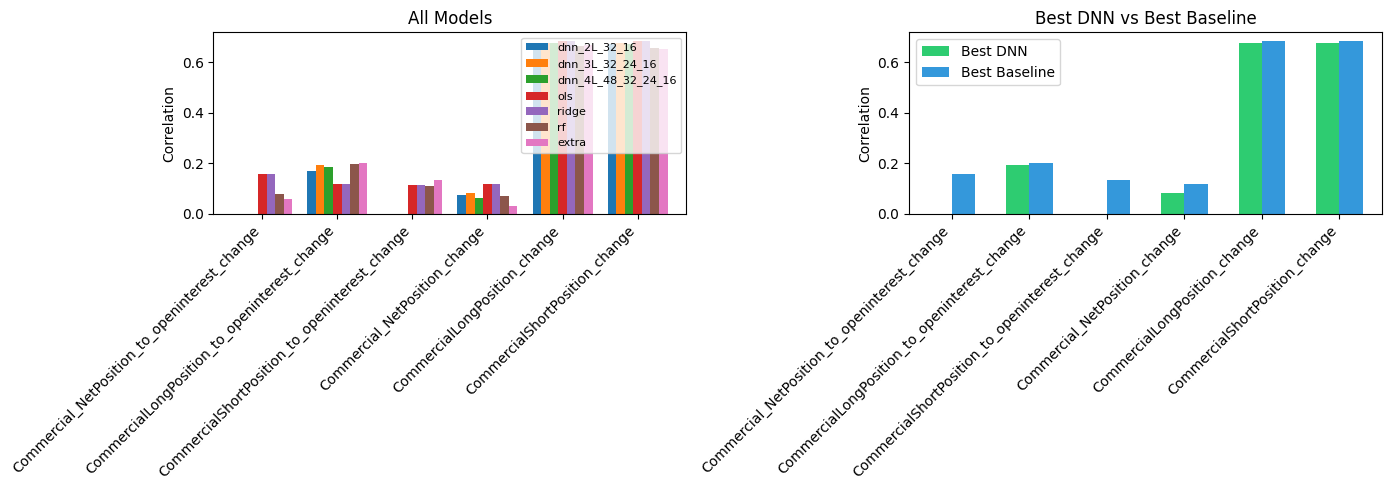

In [13]:
# Visualization
if len(results_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    results_df.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_ylabel('Correlation')
    axes[0].set_title('All Models')
    axes[0].legend(fontsize=8, loc='upper right')
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    comparison = pd.DataFrame({'Best DNN': results_df[dnn_cols].max(axis=1), 'Best Baseline': results_df[baseline_cols].max(axis=1)})
    comparison.plot(kind='bar', ax=axes[1], width=0.6, color=['#2ecc71', '#3498db'])
    axes[1].set_ylabel('Correlation')
    axes[1].set_title('Best DNN vs Best Baseline')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Save results
results_dict = {col: {idx: (float(results_df.loc[idx, col]) if not np.isnan(results_df.loc[idx, col]) else None) for idx in results_df.index} for col in results_df.columns}
with open("wti_cot_comm_nowcast_dnn_comparison.json", "w") as f:
    json.dump(results_dict, f, indent=2)
print("Results saved to wti_cot_comm_nowcast_dnn_comparison.json")

Results saved to wti_cot_comm_nowcast_dnn_comparison.json


In [15]:
# Summary
print("="*80 + "\nSUMMARY: DNN Evaluation for WTI COT Commercial Nowcasting\n" + "="*80)

if dnn_cols:
    dnn_wins = sum(1 for m in results_df.dropna(how='all').idxmax(axis=1) if str(m).startswith('dnn_'))
    total = len(results_df.dropna(how='all'))
    print(f"\nDNN wins: {dnn_wins}/{total} responses")
    
    dnn_avg = results_df[dnn_cols].max(axis=1).mean()
    baseline_avg = results_df[baseline_cols].max(axis=1).mean()
    print(f"Best DNN avg: {dnn_avg:.4f}, Best Baseline avg: {baseline_avg:.4f}")
    print(f"Difference: {dnn_avg - baseline_avg:+.4f}")
    
    if dnn_avg > baseline_avg:
        print("\n=> DNNs outperform baselines on average!")
    else:
        print("\n=> Baselines perform better (common for small tabular datasets)")

SUMMARY: DNN Evaluation for WTI COT Commercial Nowcasting

DNN wins: 0/6 responses
Best DNN avg: 0.4074, Best Baseline avg: 0.3308
Difference: +0.0766

=> DNNs outperform baselines on average!
